<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# Модель предсказания кол-ва заказов такси

Перед нами исторические данные о поездках такси, собранные правительством города Чикаго за 2022 и 2023 года. Данные предоставлены сайтом **Chicago Data Portal** ([2022 год](https://data.cityofchicago.org/Transportation/Taxi-Trips-2022/npd7-ywjz), [2023 год](https://data.cityofchicago.org/Transportation/Taxi-Trips-2023/e55j-2ewb))

Цель работы: Разработать модель машинного обучения, способную предсказывать количество заказов на каждом округе на следующий час. Это может помочь правильно рассредотачивать водителей такси в зависимости от потребностей района, снизить среднее время ожидания машины клиентом и, как следствие, возможно благоприятно скажется на загруженности дорог города.

**Описание данных:**
- Trip ID - Уникальный идентификатор поездки.
- Taxi ID - Уникальный идентификатор такси.
- Trip Start Timestamp - Время начала поездки (округляется до ближайших 15 минут).
- Trip End Timestamp - Когда поездка закончилась (округляется до ближайших 15 минут).
- Trip Seconds - Время поездки в секундах.
- Trip Miles - Расстояние поездки в милях.
- Pickup Census Tract - Переписной тракт, где началась поездка. В целях конфиденциальности этот переписной участок не отображается для некоторых поездок (этот столбец часто будет пустым для мест за пределами Чикаго).
- Dropoff Census Tract - Переписной тракт, где закончилась поездка. В целях конфиденциальности этот переписной участок не отображается для некоторых поездок (этот столбец часто будет пустым для мест за пределами Чикаго).
- Pickup Community Area - Общественная зона, где началось путешествие (этот столбец будет пустым для местоположений за пределами Чикаго). 
- Dropoff Community Area - Общественная зона, где закончилась поездка (этот столбец будет пустым для местоположений за пределами Чикаго).
- Fare - Стоимость поездки.
- Tips - Чаевые (денежные чаевые обычно не учитываются).
- Tolls - Стоимость проезда.
- Extras - Дополнительные расходы на поездку.
- Trip Total - Общая стоимость поездки (сумма предыдущих столбцов).
- Payment Type - Вид оплаты.
- Company - Компания-перевозчик.
- Pickup Centroid Latitude - Широта центра переписного участка или общественной территории, если переписной участок был скрыт в целях конфиденциальности. Этот столбец часто будет пустым для мест за пределами Чикаго.
- Pickup Centroid Longitude - Долгота центра переписного участка или общественной территории, если переписной участок был скрыт в целях конфиденциальности. Этот столбец часто будет пустым для мест за пределами Чикаго.
- Pickup Centroid Location - Местоположение центра переписного участка или общественной территории, если переписной участок был скрыт в целях конфиденциальности. Этот столбец часто будет пустым для мест за пределами Чикаго.
- Dropoff Centroid Latitude - Широта центра переписного участка или общественной территории, если переписной участок был скрыт в целях конфиденциальности. Этот столбец часто будет пустым для мест за пределами Чикаго.
- Dropoff Centroid Longitude - Долгота центра переписного участка или общественной территории, если переписной участок был скрыт в целях конфиденциальности. Этот столбец часто будет пустым для мест за пределами Чикаго.
- Dropoff Centroid  Location - Местоположение центра переписного участка или общественной территории, если переписной участок был скрыт в целях конфиденциальности. Этот столбец часто будет пустым для мест за пределами Чикаго.

## Изучение общей информации о данных

In [415]:
# Импортируем библиотеки
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor, FMRegressor
from xgboost.spark import SparkXGBRegressor
from pyspark.mllib.evaluation import RegressionMetrics
from sklearn.metrics import mean_squared_error, r2_score

# RandomState
state = 16082023

In [138]:
# Создаём сессию
SPARK_MASTER_IP = '172.18.0.2' 
spark = SparkSession.builder.appName("pyspark-taxi-forecasting").master(f"spark://{SPARK_MASTER_IP}:7077").config("spark.executor.cores", 1).config("spark.task.cpus", 1).config("spark.driver.memory", "10g").getOrCreate()

In [139]:
# Загружаем данные
df_2022 = spark.read.csv("datasets/Taxi_Trips_-_2022.csv", header = True, inferSchema = True)
df_2023 = spark.read.csv("datasets/Taxi_Trips_-_2023.csv", header = True, inferSchema = True)

In [140]:
# Выводим кол-во строк в датафрейме, примеры строк, схему и описательные статистики
for df, name in zip([df_2022, df_2023], ['Taxi_Trips_-_2022', 'Taxi_Trips_-_2023']):
    df = df.fillna(0)
    print('Краткий обзор датафрейма', '\033[1m' + name + '\033[0m')
    print(f'Количество строк в датафрейме: {df.count()}')
    print('Колонки и их типы данных:')
    print(df.printSchema())
    print('Первые 5 строк датафрейма:')
    print(df.select(df[0], df[1], df[2], df[3], df[4], df[5], df[6], df[7], df[8], df[9], df[10]).show(5))
    print(df.select(df[11], df[12], df[13], df[14], df[15], df[16], df[17], df[18], df[20], df[21], df[22]).show(5))
    print('Описательные статистики датафрейма:')
    print(df.select(df[2], df[3], df[4], df[5], df[6], df[7], df[8], df[9]).summary().show())
    print(df.select(df[10], df[11], df[12], df[13], df[14]).summary().show())
    print()
    print('---------------------------------------------------------------------------------------------------------------')
    print()

Краткий обзор датафрейма Taxi_Trips_-_2022
Количество строк в датафрейме: 6382425
Колонки и их типы данных:
root
 |-- Trip ID: string (nullable = true)
 |-- Taxi ID: string (nullable = true)
 |-- Trip Start Timestamp: string (nullable = true)
 |-- Trip End Timestamp: string (nullable = true)
 |-- Trip Seconds: integer (nullable = true)
 |-- Trip Miles: double (nullable = false)
 |-- Pickup Census Tract: long (nullable = true)
 |-- Dropoff Census Tract: long (nullable = true)
 |-- Pickup Community Area: integer (nullable = true)
 |-- Dropoff Community Area: integer (nullable = true)
 |-- Fare: double (nullable = false)
 |-- Tips: double (nullable = false)
 |-- Tolls: double (nullable = false)
 |-- Extras: double (nullable = false)
 |-- Trip Total: double (nullable = false)
 |-- Payment Type: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Pickup Centroid Latitude: double (nullable = false)
 |-- Pickup Centroid Longitude: double (nullable = false)
 |-- Pickup Centroi

## EDA

Объединим данные за 2022 и 2023 года в один датафрейм

In [141]:
df = df_2022.union(df_2023)

Поменяем тип данных колонок 'Trip Start Timestamp' и 'Trip End Timestamp' на timestamp

In [144]:
for col in ['Trip Start Timestamp', 'Trip End Timestamp']:
    df = df.withColumn(
        col,
        to_timestamp(
            unix_timestamp(
                col,
                'MM/dd/yyyy hh:mm:ss a'
            )
        )
    )
    
    
    df_2022 = df_2022.withColumn(
        col,
        to_timestamp(
            unix_timestamp(
                col,
                'MM/dd/yyyy hh:mm:ss a'
            )
        )
    )
    

Для исследовательского анализа данных будем использовать рандомизированную выборку  (1% от всех данных) за 2022 год. Это позволит нам получить примерное представление о сезонности и трендах

In [145]:
eda_df = df_2022.sample(False, 0.05).toPandas();

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/usr/local/spark/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


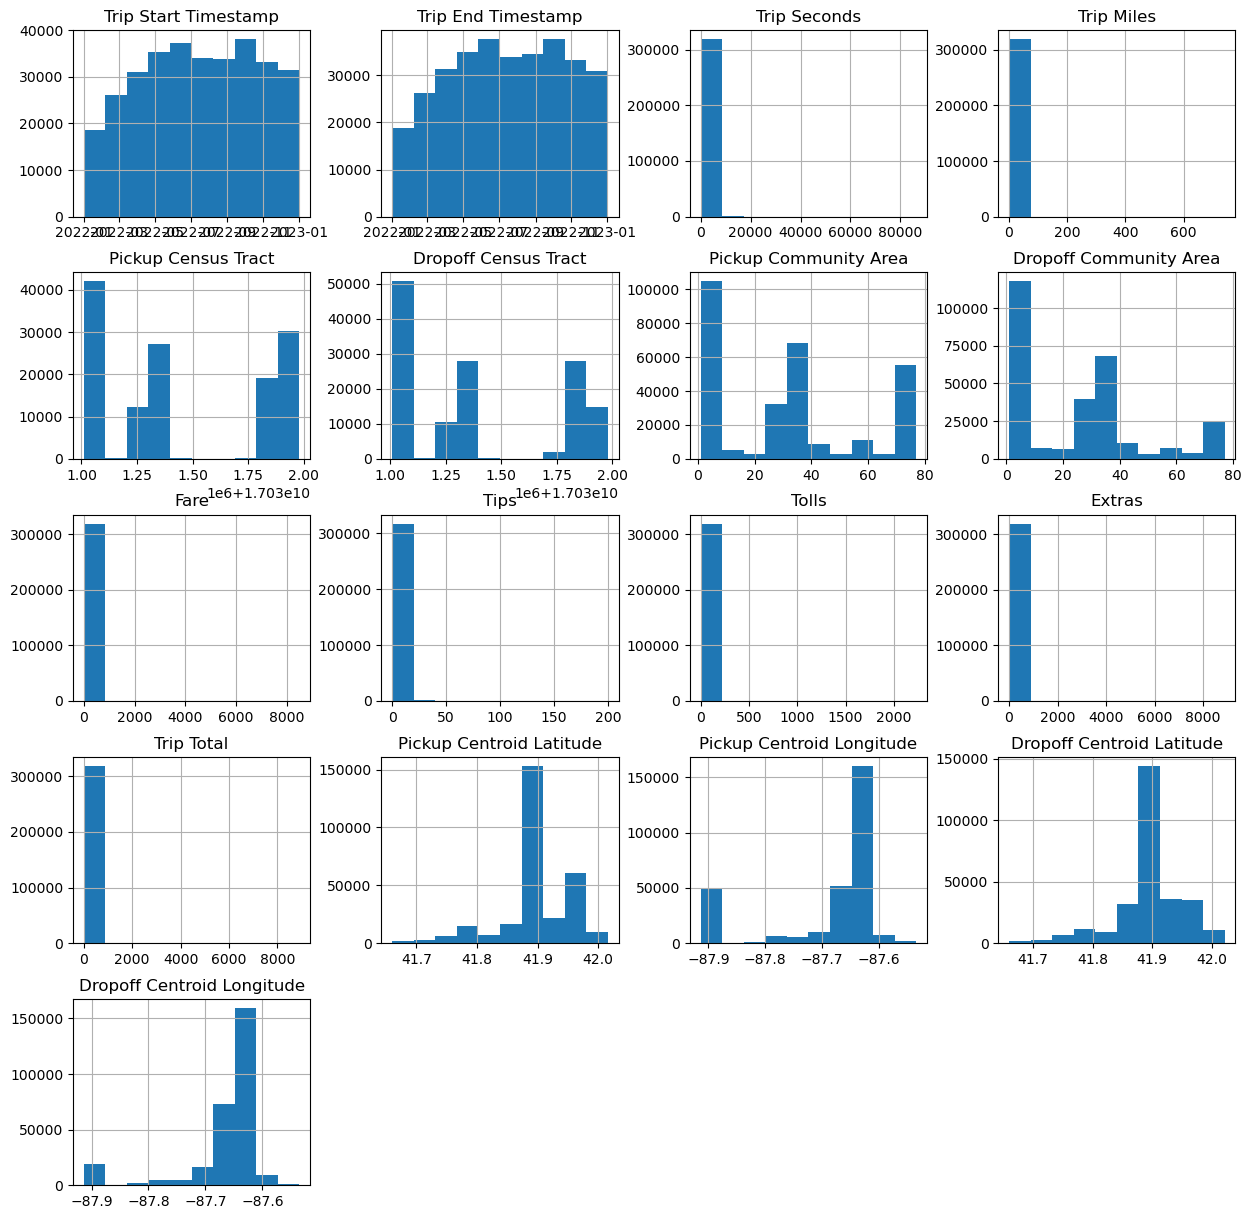

In [8]:
eda_df.hist(figsize=(15,15));

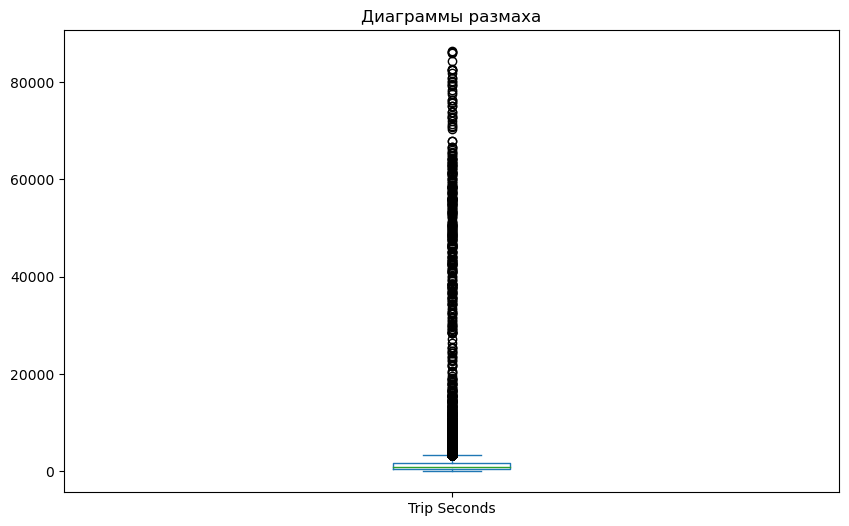

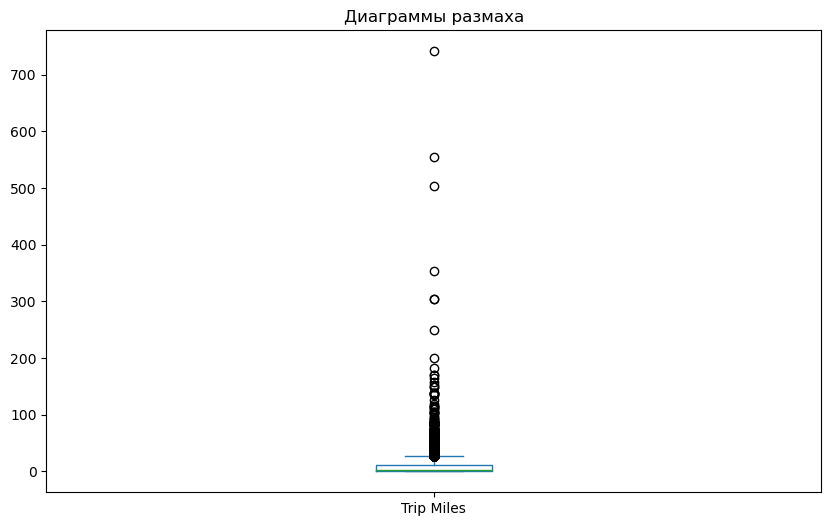

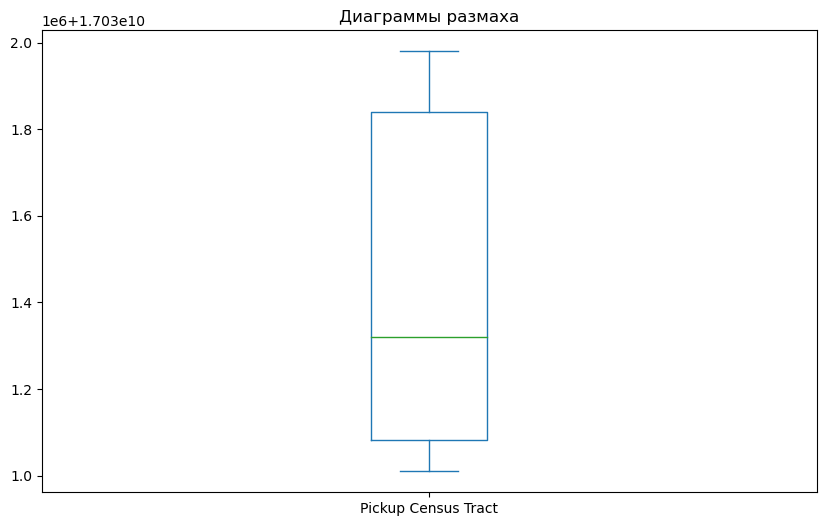

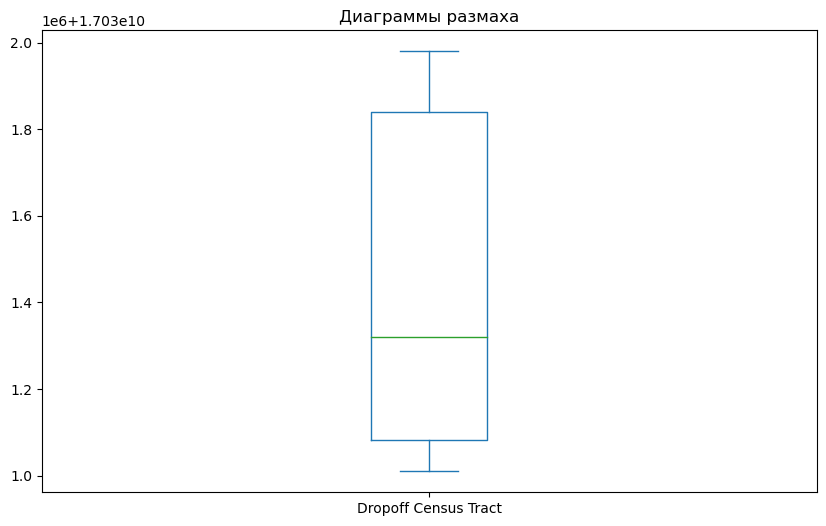

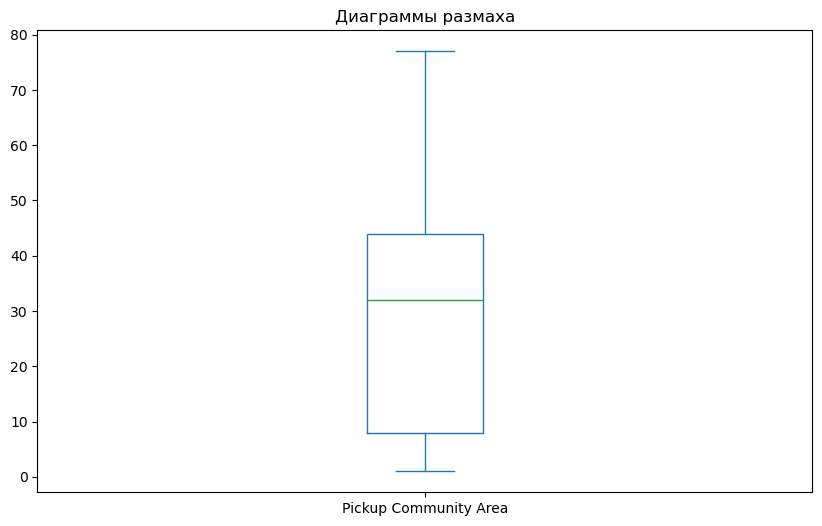

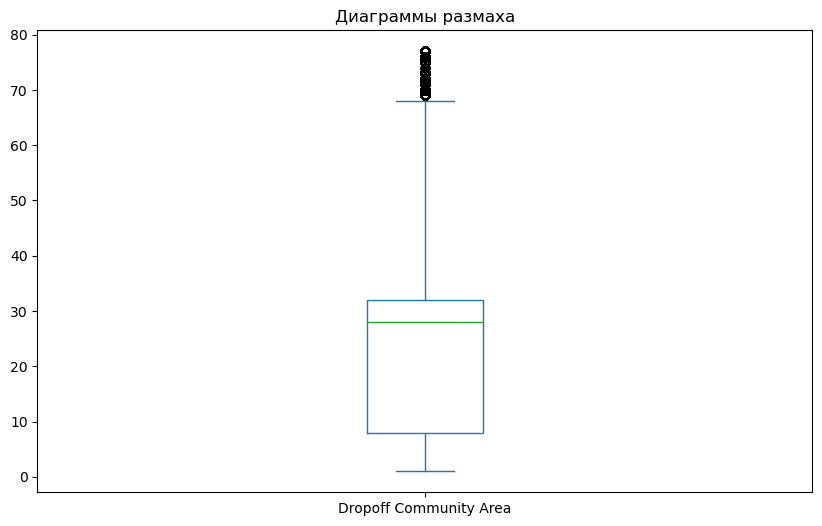

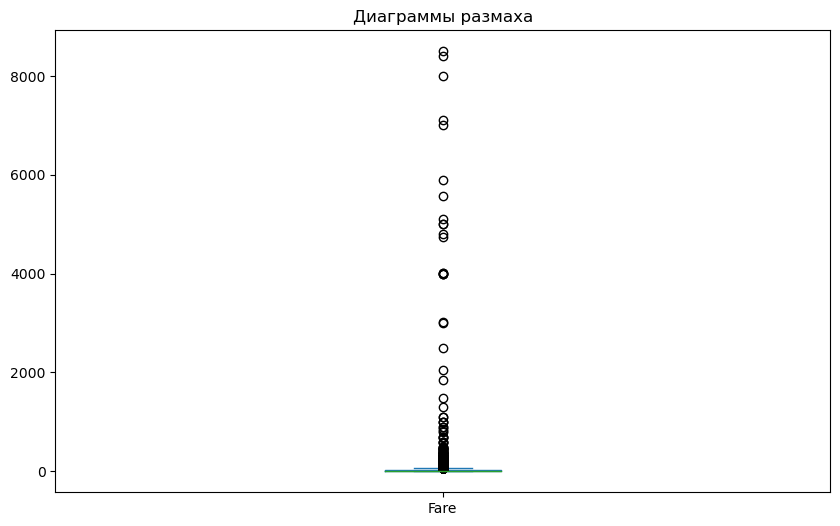

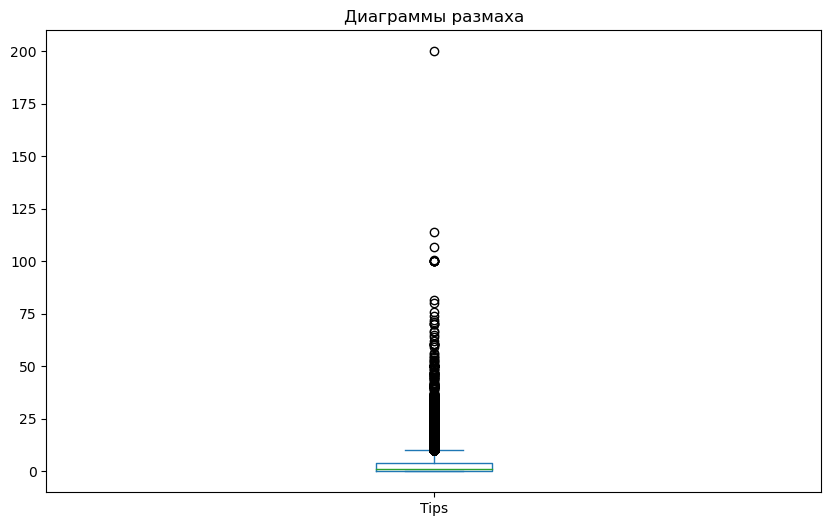

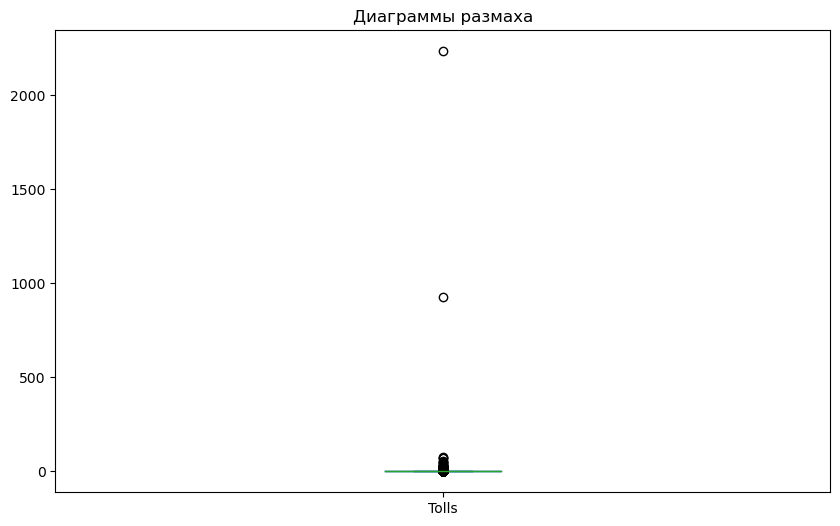

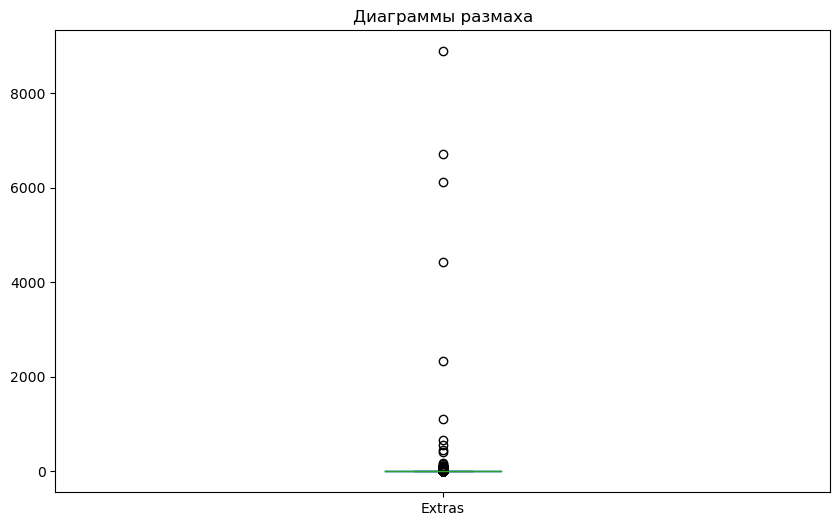

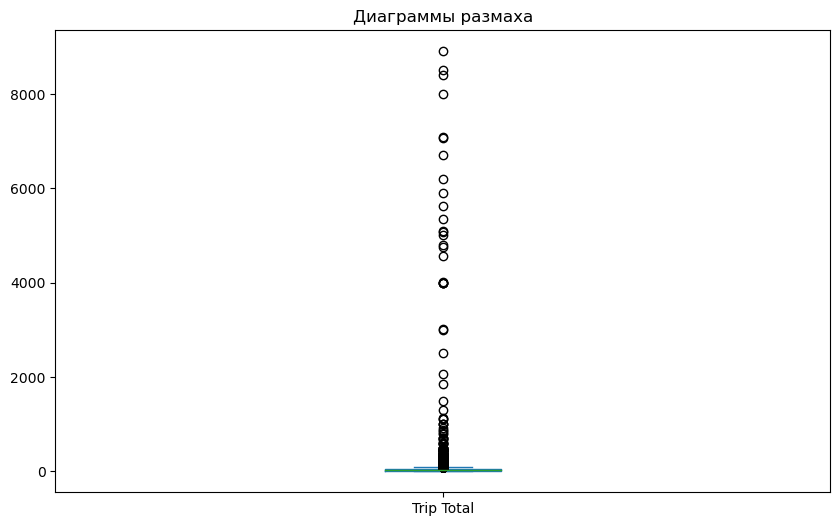

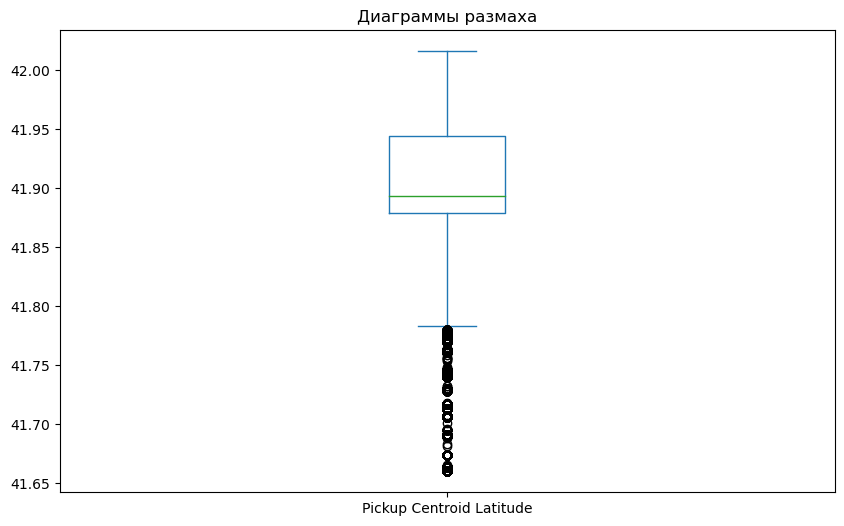

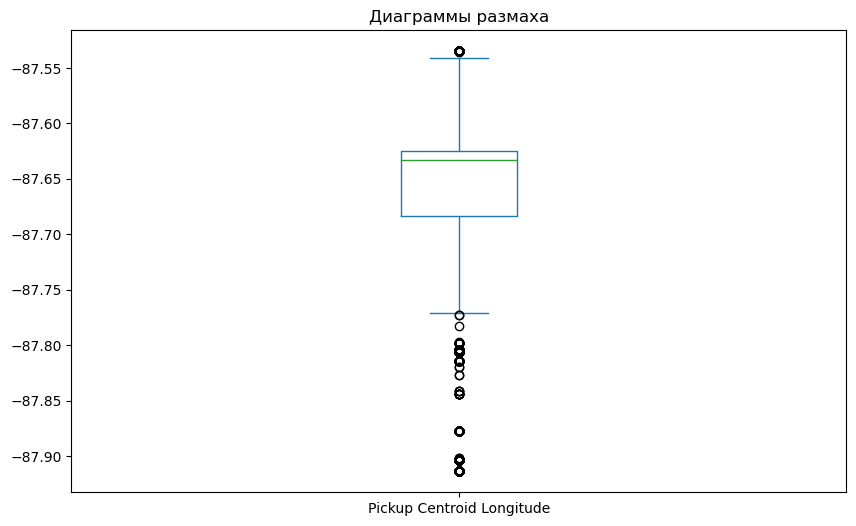

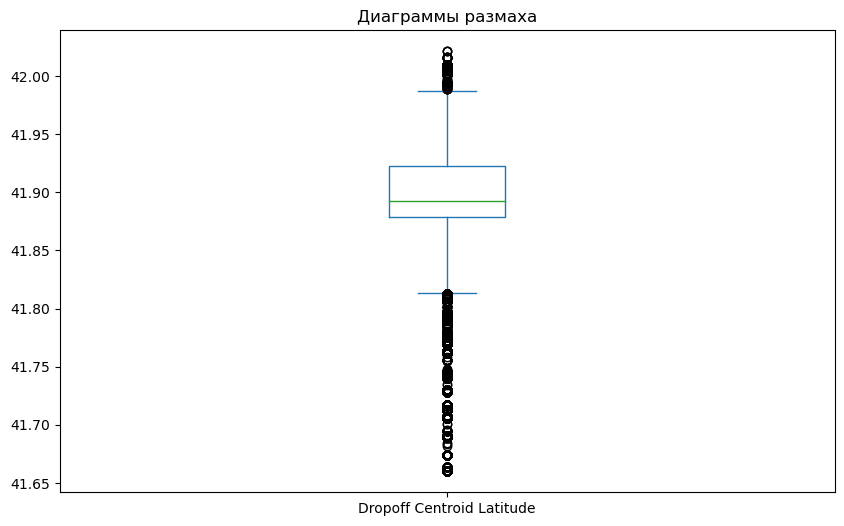

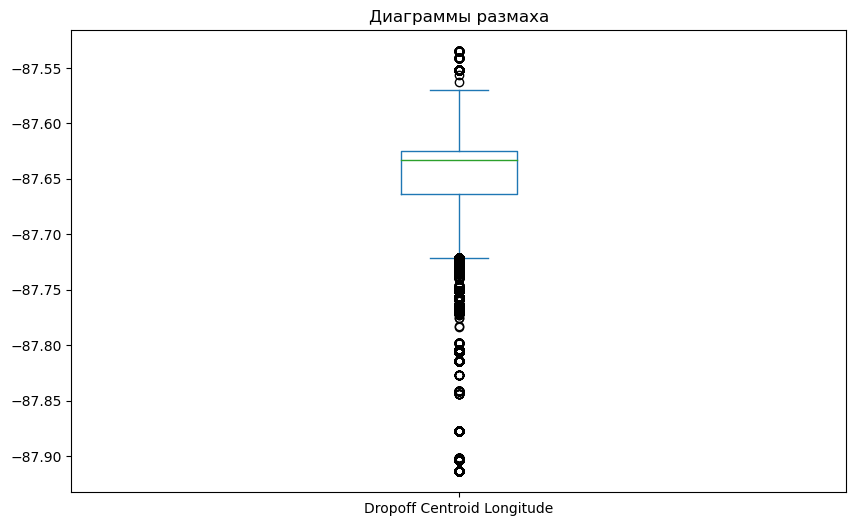

In [9]:
for col in eda_df.columns:
    try:
        eda_df[col].plot(kind='box', figsize=(10,6))
        plt.title("Диаграммы размаха")
        plt.show();
    except: continue

В данных присутствует множество выбросов

In [10]:
eda_df.corr(numeric_only=True).style.background_gradient(cmap ='seismic')\
.set_properties(**{'font-size': '12px'})

,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,Trip Total,Pickup Centroid Latitude,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude
Trip Seconds,1.000000,0.361525,0.268992,0.097527,0.194698,0.096405,0.152830,0.179683,0.000995,0.022481,0.152915,0.085209,-0.215992,0.034234,-0.121446
Trip Miles,0.361525,1.000000,0.415967,0.161292,0.445261,0.216643,0.292781,0.439298,0.000196,0.075198,0.314819,0.167101,-0.470969,0.024353,-0.233051
Pickup Census Tract,0.268992,0.415967,1.000000,0.042282,0.878077,0.034345,0.225215,0.362065,0.000884,0.085136,0.253975,0.377400,-0.751564,0.058321,-0.067830
Dropoff Census Tract,0.097527,0.161292,0.042282,1.000000,0.043344,0.804346,0.097111,0.124530,-0.000886,0.004191,0.092832,0.004623,-0.021033,0.187578,-0.612693
Pickup Community Area,0.194698,0.445261,0.878077,0.043344,1.000000,0.116426,0.178123,0.354984,0.001294,0.077682,0.210930,0.141137,-0.765604,-0.071333,-0.049305
Dropoff Community Area,0.096405,0.216643,0.034345,0.804346,0.116426,1.000000,0.094376,0.076052,0.000243,0.004196,0.086605,-0.184262,0.041334,-0.202220,-0.538705
Fare,0.152830,0.292781,0.225215,0.097111,0.178123,0.094376,1.000000,0.175713,0.000004,0.030991,0.873977,0.066002,-0.190226,0.016484,-0.110186
Tips,0.179683,0.439298,0.362065,0.124530,0.354984,0.076052,0.175713,1.000000,0.000513,0.080209,0.259783,0.249285,-0.440397,0.146333,-0.185300
Tolls,0.000995,0.000196,0.000884,-0.000886,0.001294,0.000243,0.000004,0.000513,1.000000,0.285586,0.204701,0.000593,-0.001297,0.000183,-0.001232
Extras,0.022481,0.075198,0.085136,0.004191,0.077682,0.004196,0.030991,0.080209,0.285586,1.000000,0.501750,0.044435,-0.092462,0.008421,-0.014026


Корреляции выглядят вполне логично. Интересным наблюдением кажутся явная взаимосвязь между чаевыми и районом начала поездки и широтой и взаимосвязь между районом начала поездки и расстоянием

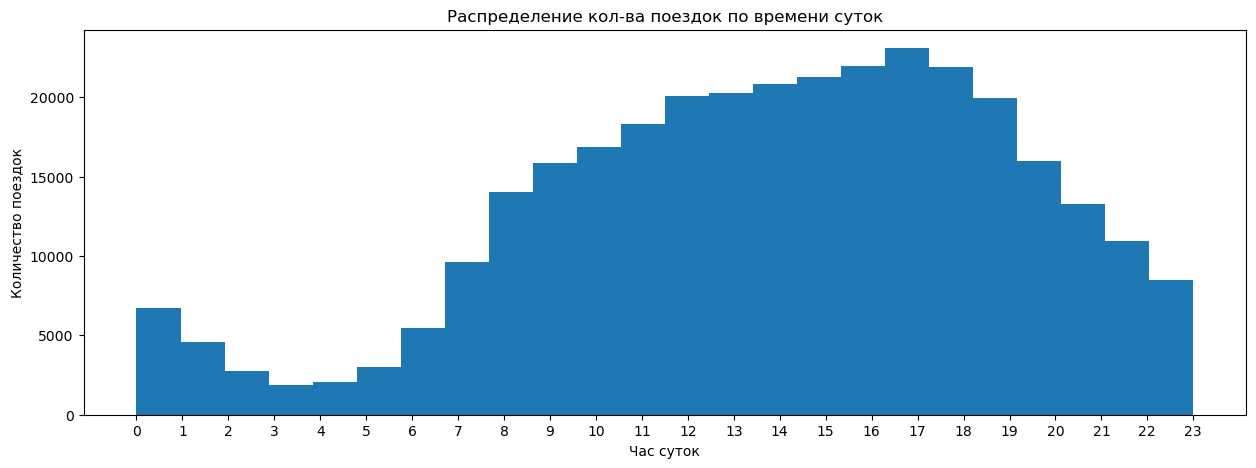

In [11]:
eda_df['Hour'] = eda_df['Trip Start Timestamp'].dt.hour
plt.figure(figsize=(15,5))
plt.hist(eda_df['Hour'], bins=24)
plt.xticks(range(0,24))
plt.title('Распределение кол-ва поездок по времени суток')
plt.xlabel('Час суток')
plt.ylabel('Количество поездок')
plt.show()

На графике видно, что час пик приходится на промежуток между 15:00 и 18:00, а в ночные часы совершается куда меньше поездок, чем днём

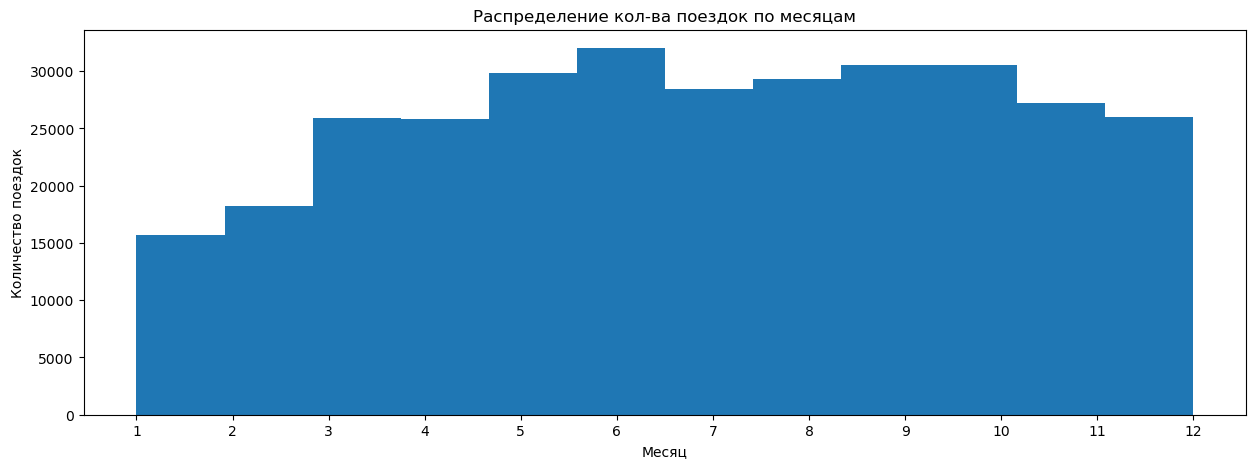

In [12]:
plt.figure(figsize=(15,5))
plt.hist(eda_df['Trip Start Timestamp'].dt.month, bins=12)
plt.xticks(range(1,13))
plt.title('Распределение кол-ва поездок по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество поездок')
plt.show()

На графике заметна определённая сезонность - летом можно увидеть пик, а к зиме наблюдается небольшой спад

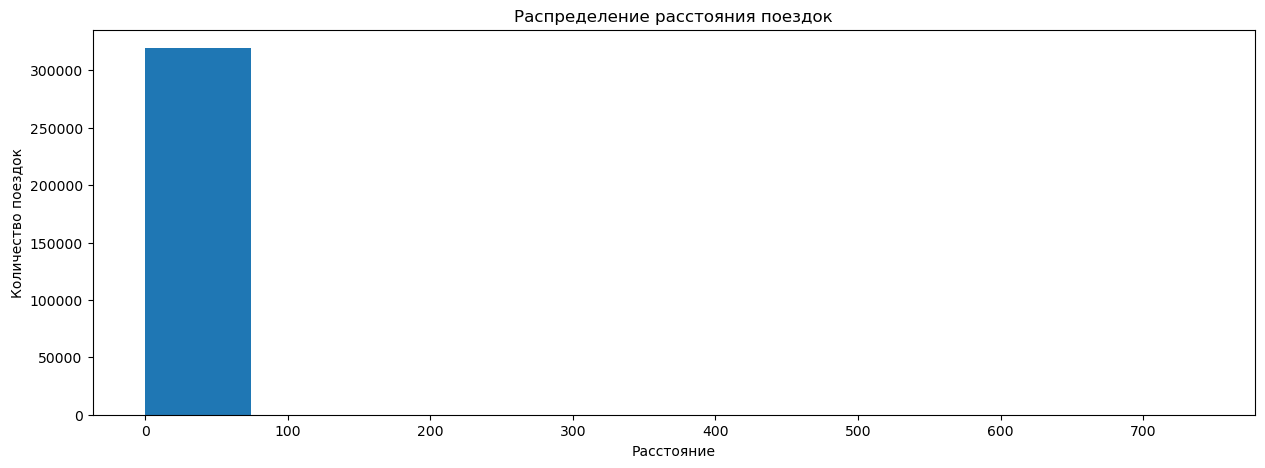

In [13]:
plt.figure(figsize=(15,5))
plt.hist(eda_df['Trip Miles'])
plt.title('Распределение расстояния поездок')
plt.xlabel('Расстояние')
plt.ylabel('Количество поездок')
plt.show()

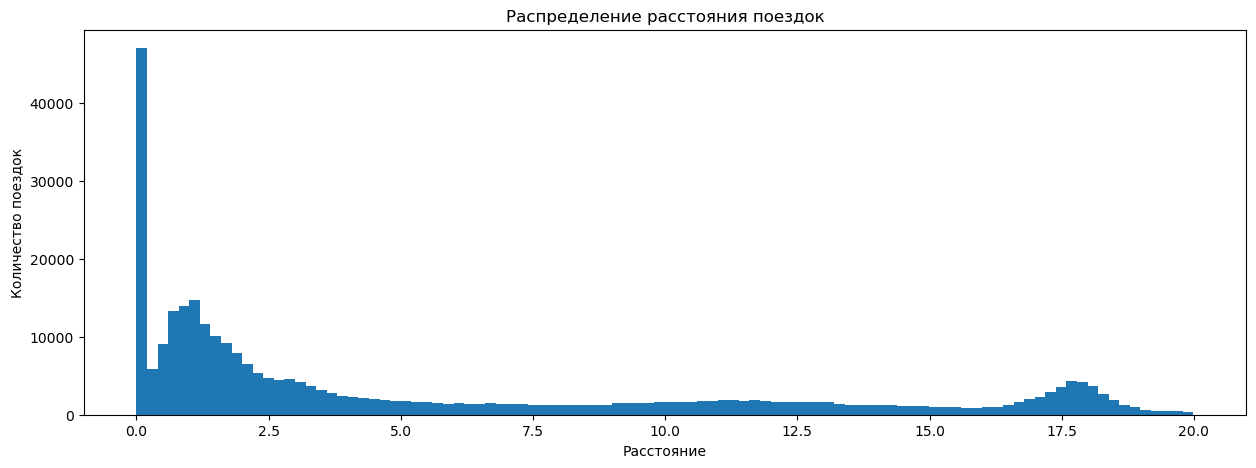

In [14]:
plt.figure(figsize=(15,5))
plt.hist(eda_df['Trip Miles'].loc[eda_df['Trip Miles'] < 20], bins=100)
plt.title('Распределение расстояния поездок')
plt.xlabel('Расстояние')
plt.ylabel('Количество поездок')
plt.show()

К сожалению, для большинства поездок расстояние не зафиксировано

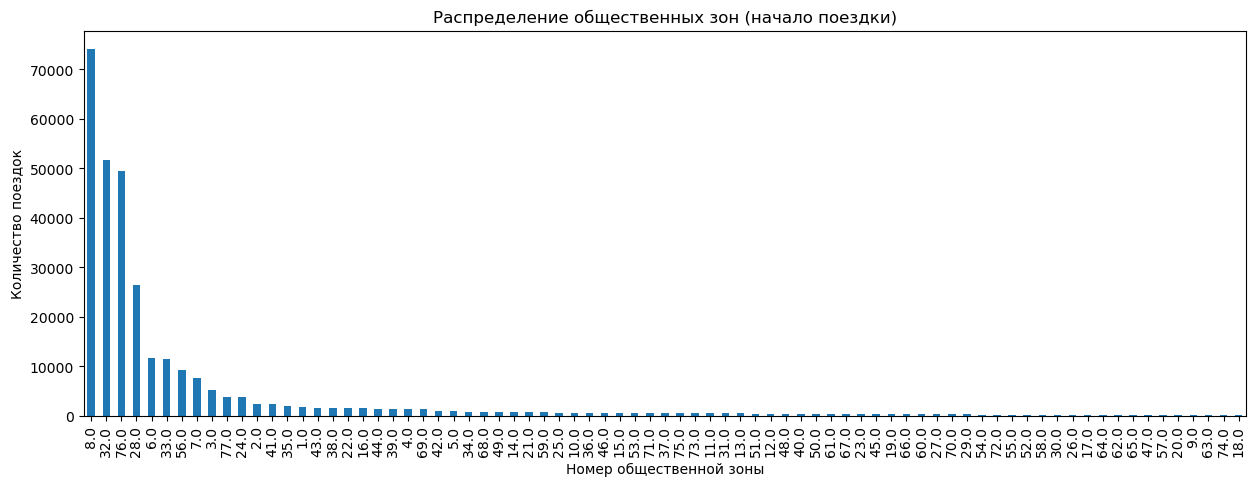

In [15]:
plt.figure(figsize=(15,5))
eda_df['Pickup Community Area'].value_counts().plot(kind='bar')
plt.title('Распределение общественных зон (начало поездки)')
plt.xlabel('Номер общественной зоны')
plt.ylabel('Количество поездок')
plt.show()

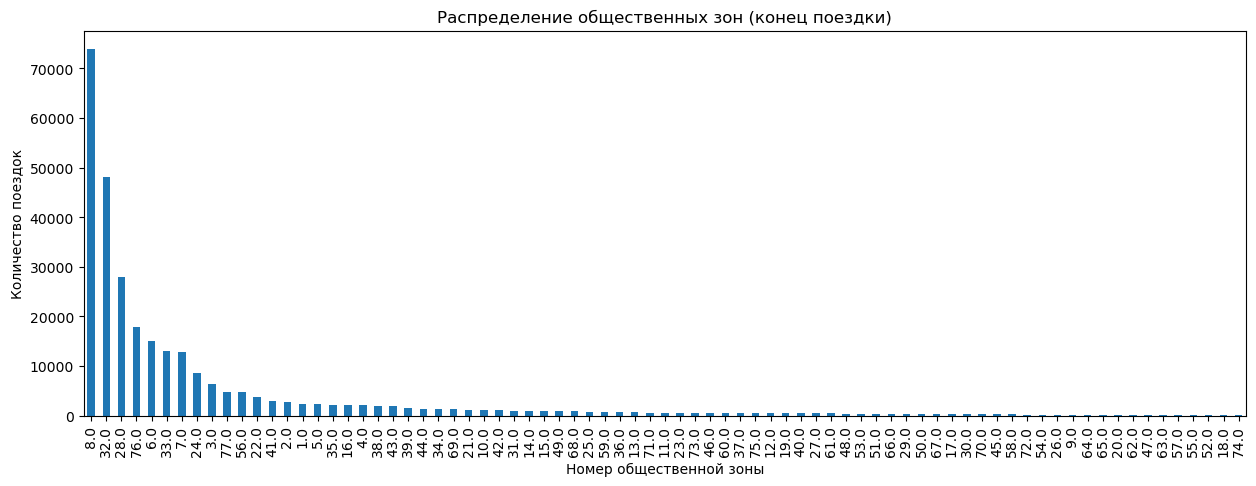

In [16]:
plt.figure(figsize=(15,5))
eda_df['Dropoff Community Area'].value_counts().plot(kind='bar')
plt.title('Распределение общественных зон (конец поездки)')
plt.xlabel('Номер общественной зоны')
plt.ylabel('Количество поездок')
plt.show()

8 общественная зона опредённо является самой популярной. Для многих округов данные предоставлены в крайне малом объёме, вряд ли модель сможет хорошо их объяснить.

In [54]:
temp_df = eda_df.drop(
    [
        'Trip End Timestamp', 
        'Pickup Census Tract','Dropoff Census Tract',
        'Dropoff Community Area', 'Payment Type', 
        'Company', 'Pickup Centroid Latitude',
        'Pickup Centroid Longitude', 'Pickup Centroid Location',
        'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude',
        'Dropoff Centroid  Location', 'Hour'
    ], axis=1
)

unique_id_count = temp_df.groupby(temp_df['Trip Start Timestamp'].dt.ceil("H"))['Taxi ID'].nunique()
trip_count = temp_df.groupby(temp_df['Trip Start Timestamp'].dt.ceil("H"))['Trip ID'].nunique()

temp_df = temp_df.groupby(
    [temp_df['Trip Start Timestamp'].dt.ceil("H")]
)[
    'Trip Seconds', 'Trip Miles', 'Fare', 
    'Tips', 'Tolls', 'Extras', 'Trip Total'
].sum()

temp_df['Unique Taxi ID Count'] = unique_id_count
temp_df['Trip Count'] = trip_count
temp_df.index = pd.to_datetime(temp_df.index)

new_names = []
for col in temp_df.columns:
    new_names.append(col.lower().replace(" ", "_"))
temp_df.columns = new_names

/tmp/ipykernel_962/1697882597.py:16: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp_df = temp_df.groupby(


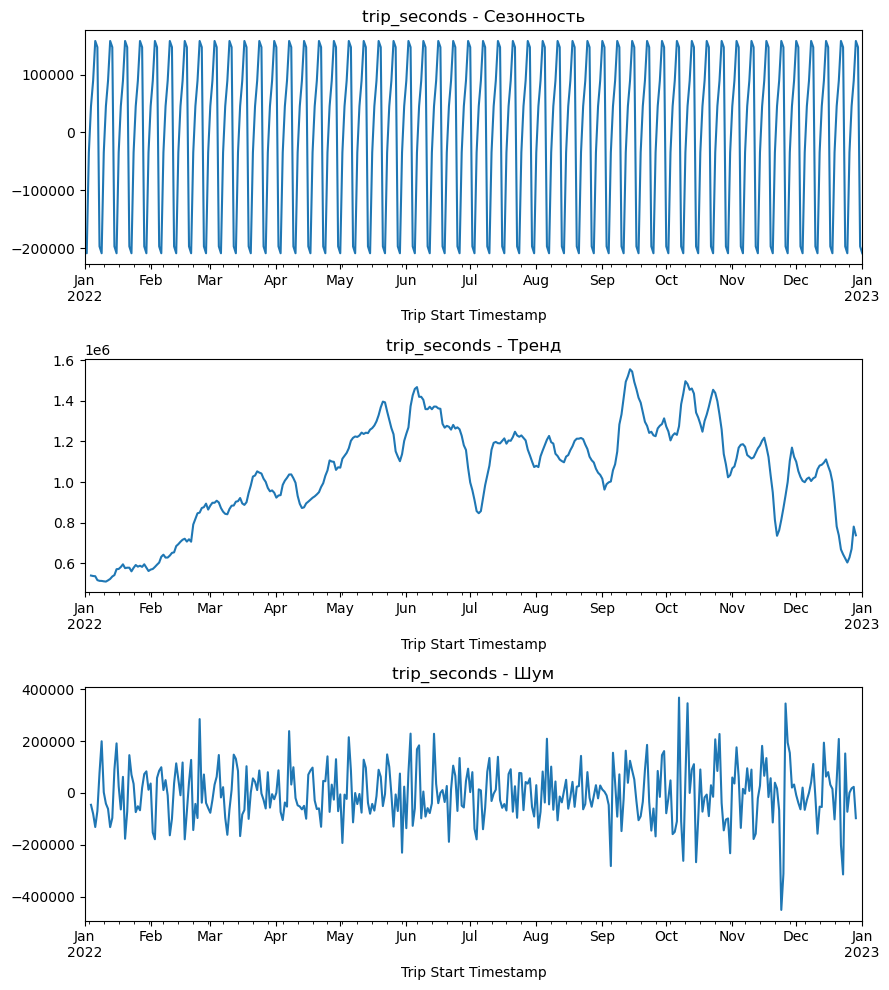

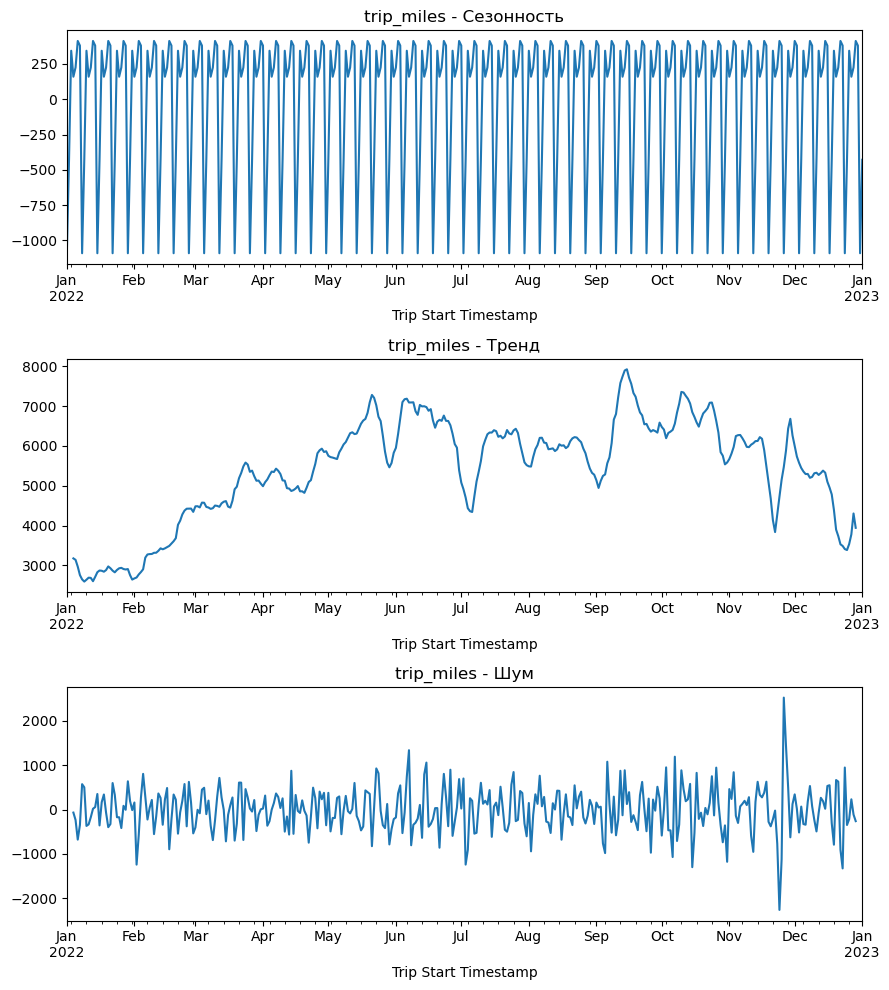

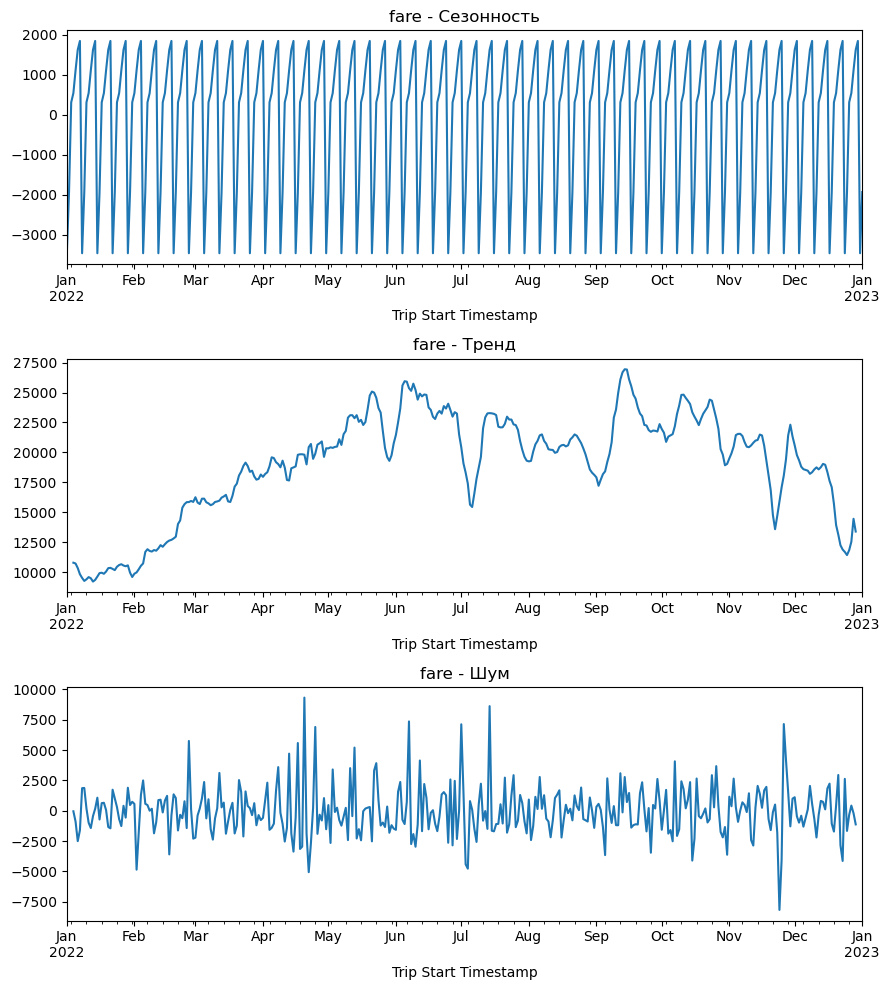

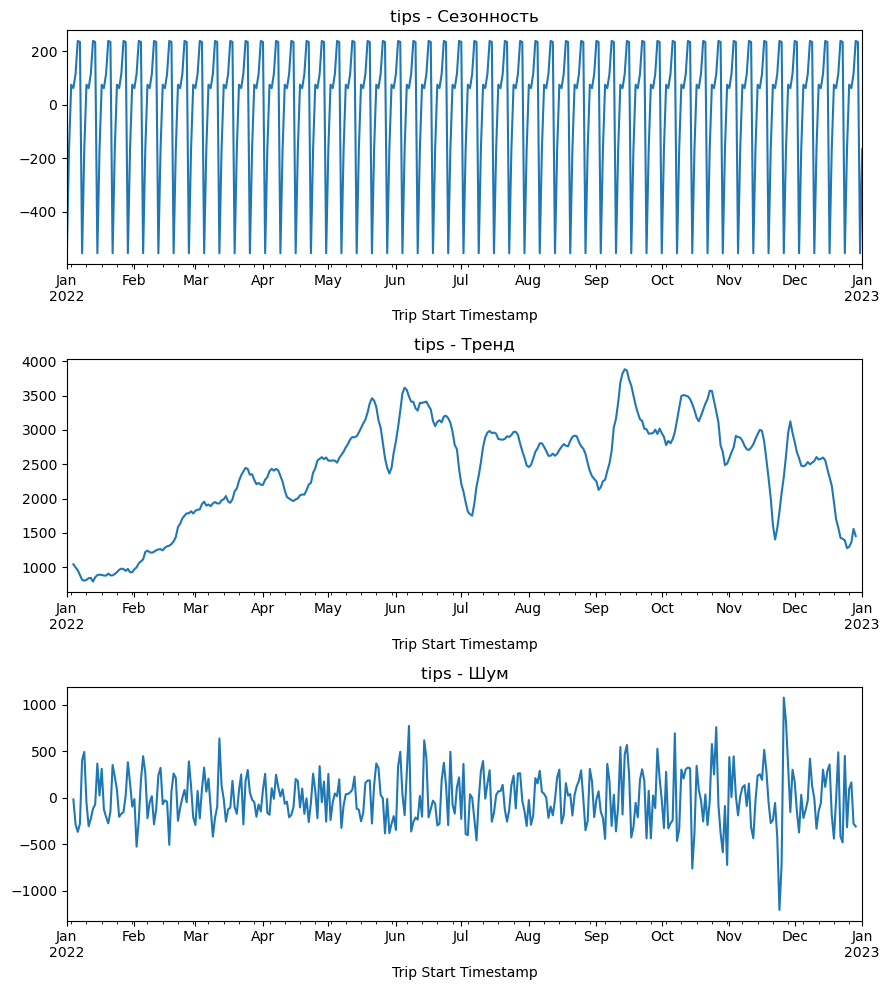

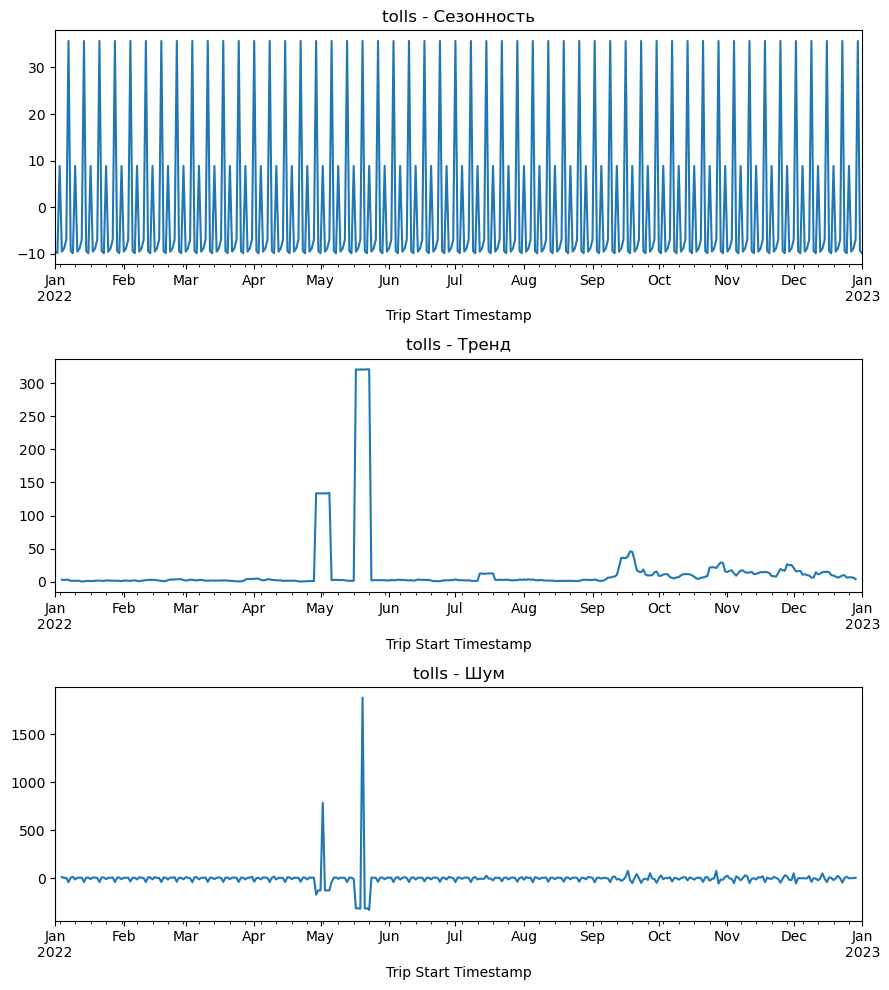

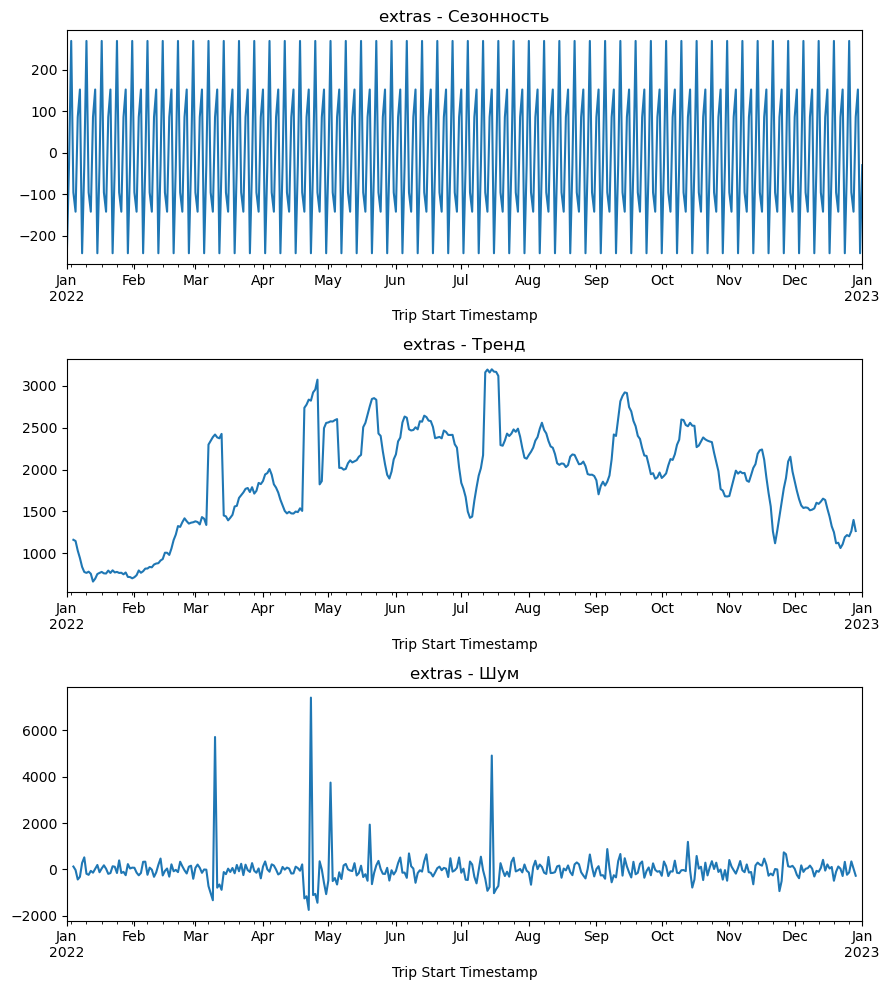

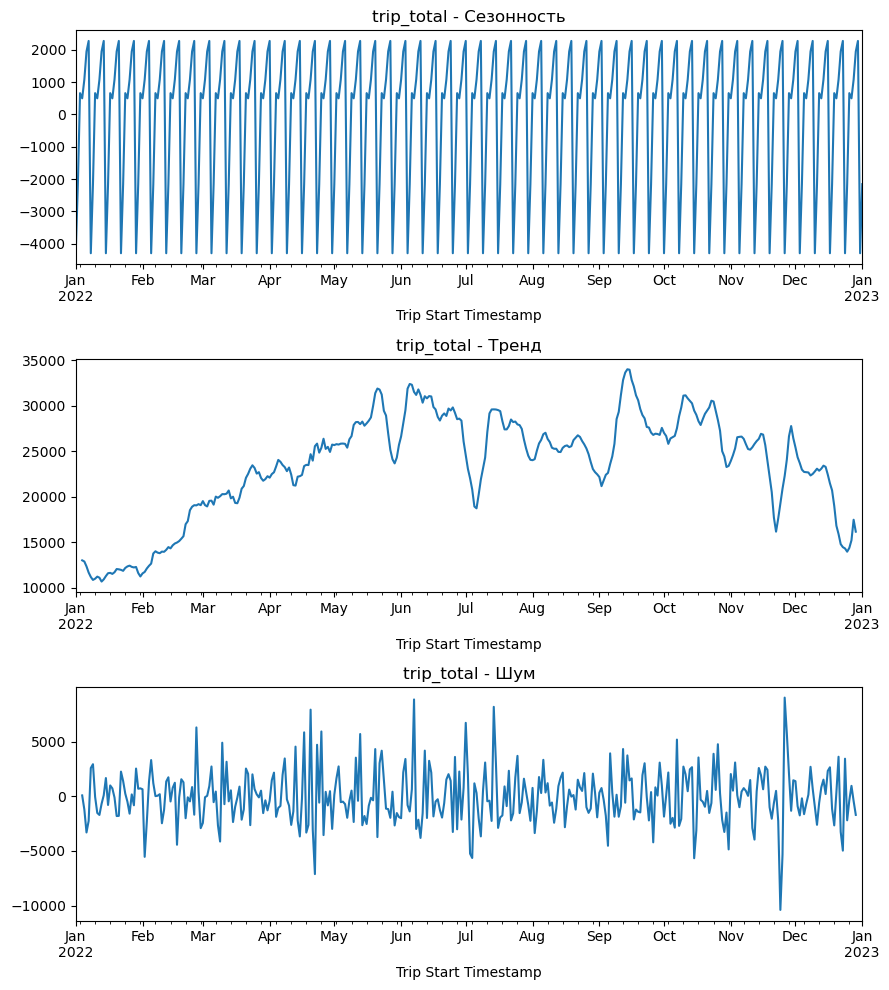

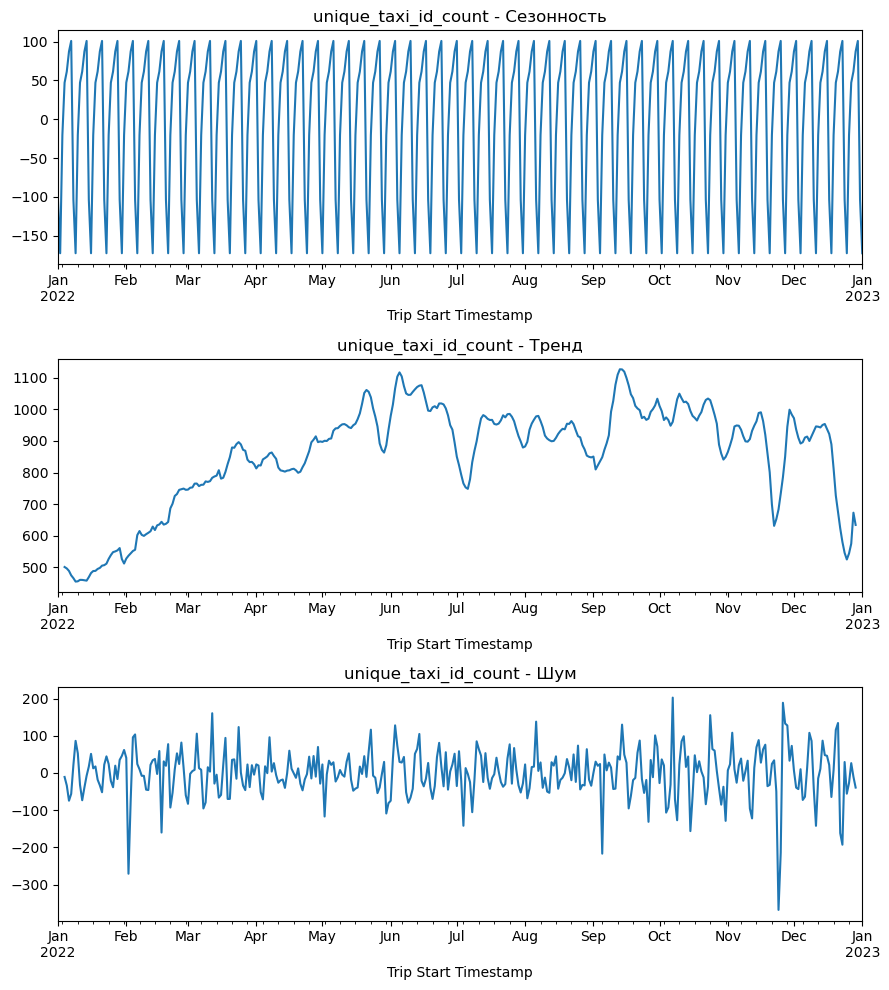

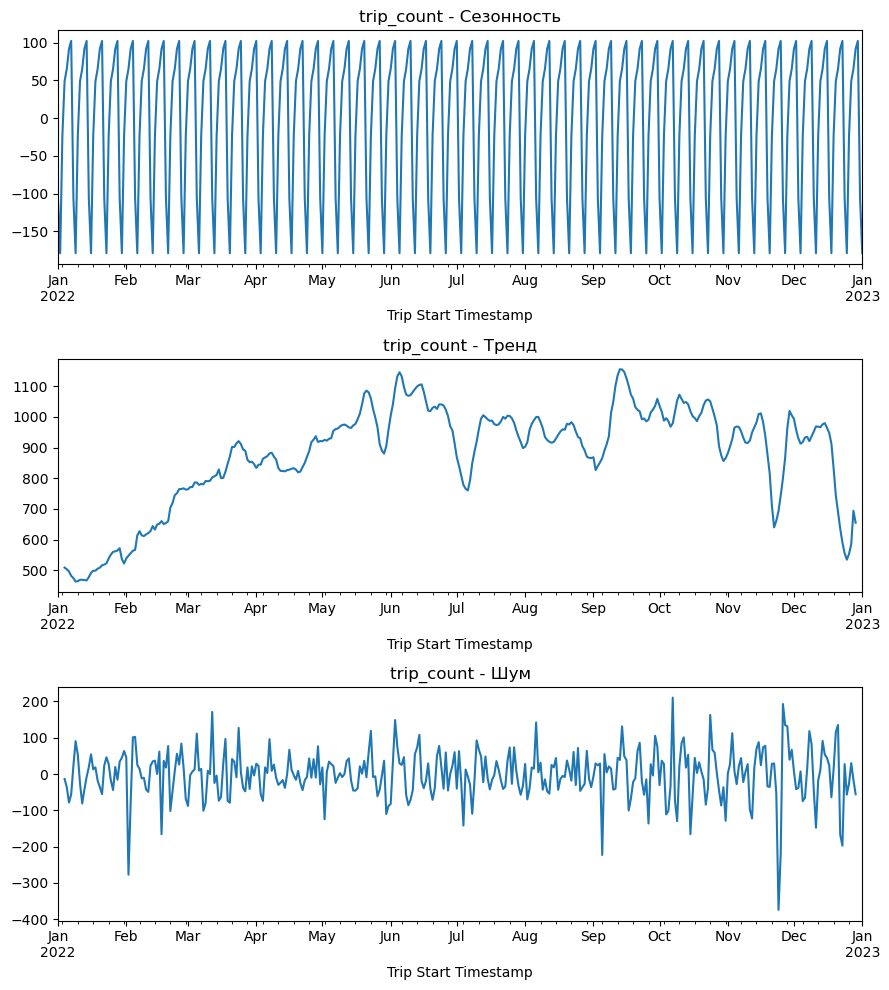

In [56]:
temp_df_1year = temp_df.resample('1D').sum()
df_decomposed = temp_df_1year.apply(lambda x: seasonal_decompose(x, model='additive'))

for decomposed, name in zip(df_decomposed, temp_df_1year.columns):
    plt.figure(figsize=(9, 10))
    plt.subplot(311)
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title(f'{name} - Сезонность')
    plt.subplot(312)
    decomposed.trend.plot(ax=plt.gca())
    plt.title(f'{name} - Тренд')
    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca())
    plt.title(f'{name} - Шум')
    plt.tight_layout()
    plt.show();

В данных много шума, хорошо прослеживается недельная сезонность.

Выведем графики с плавающими средним и стандартным отклонением (данные ресемплированы по интервалам в 1 день, сглаживание по 10 дням)

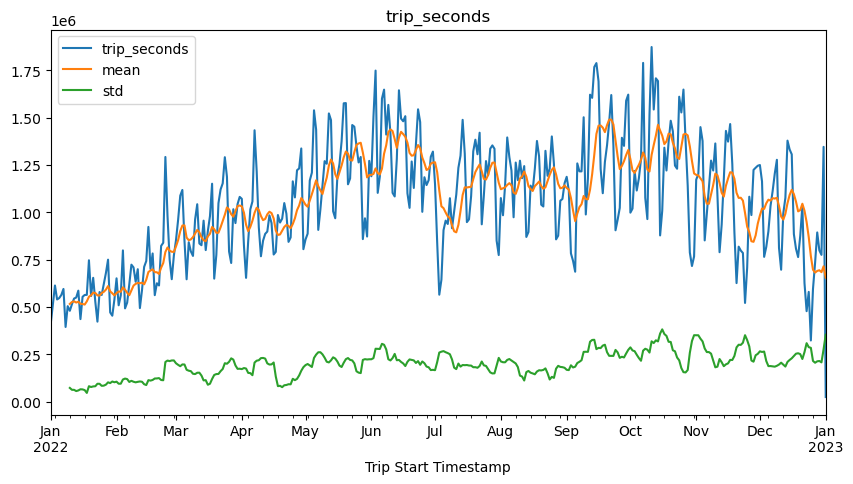

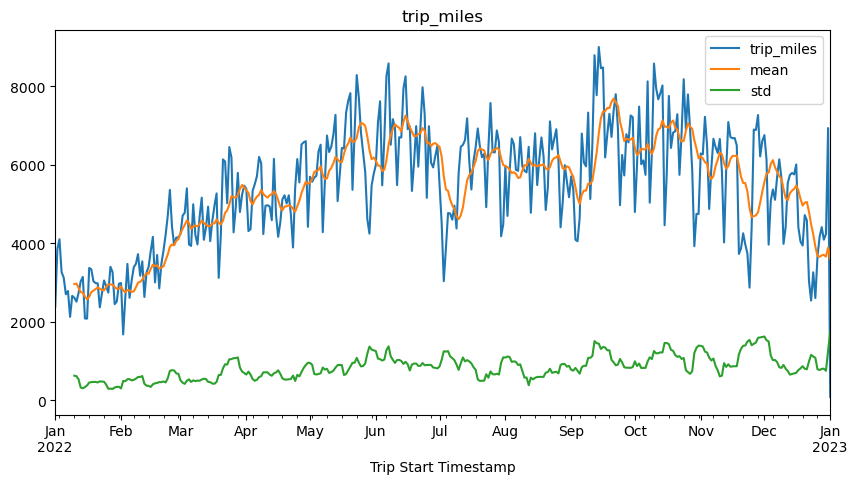

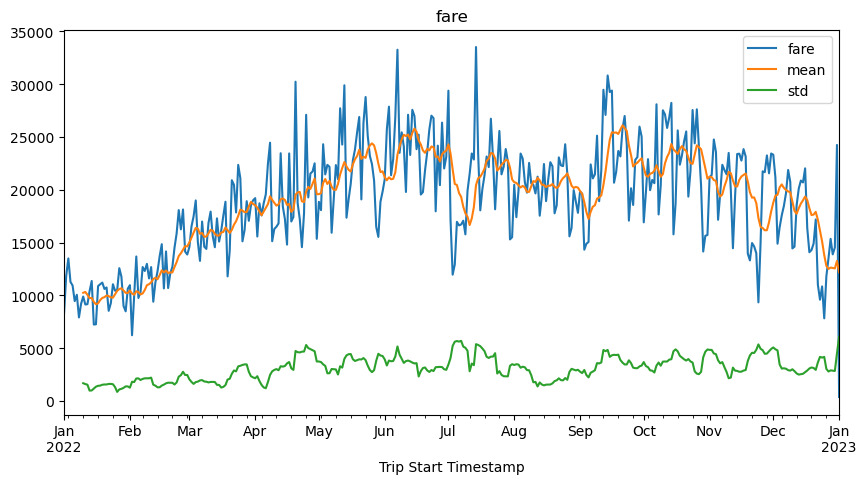

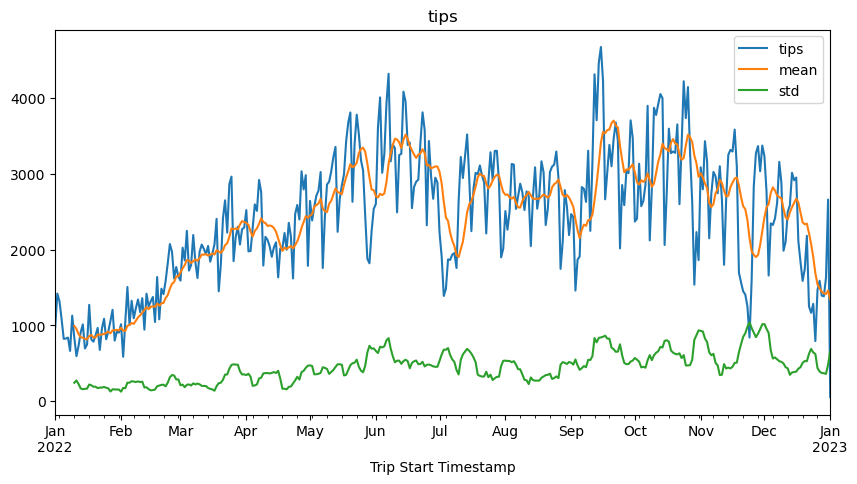

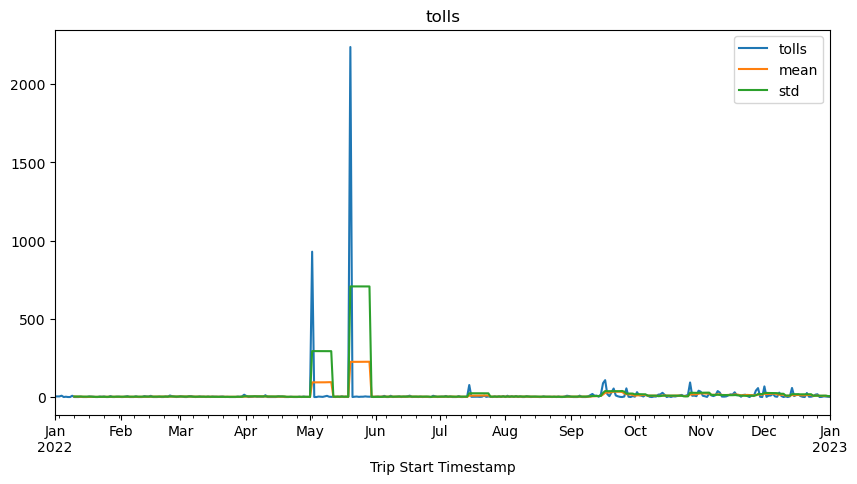

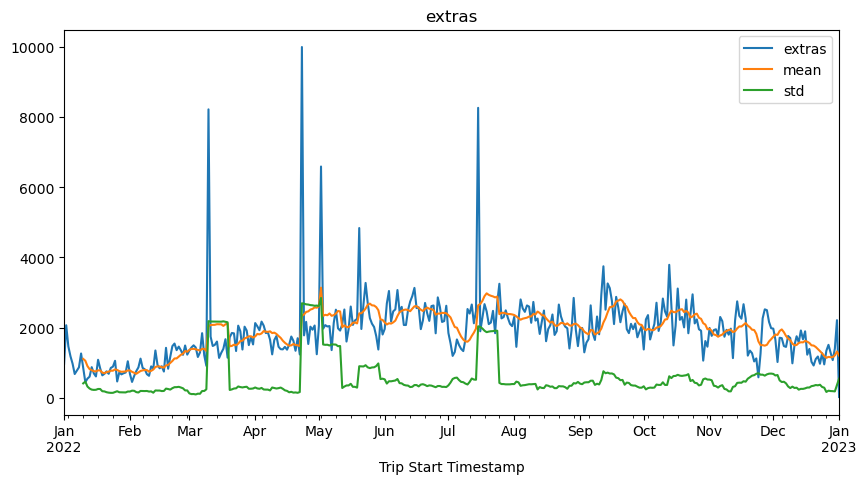

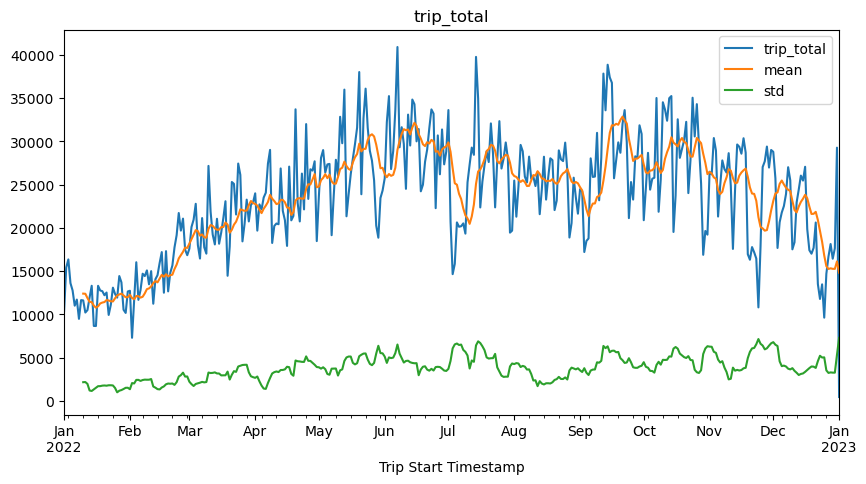

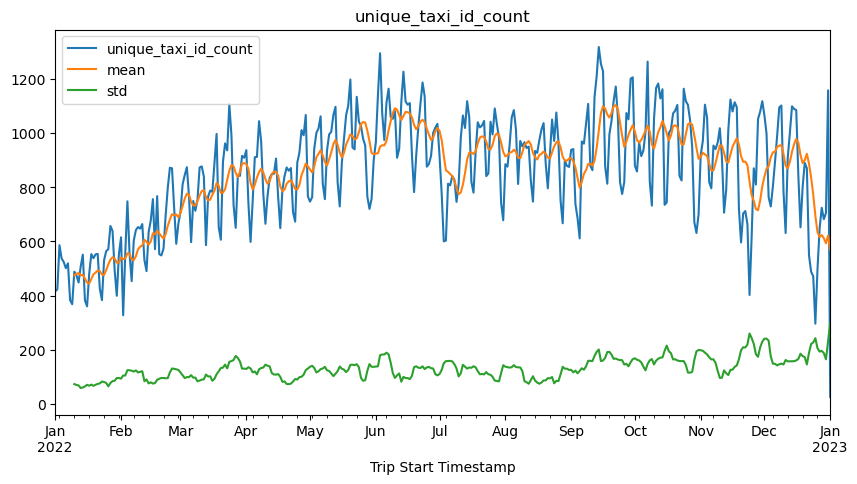

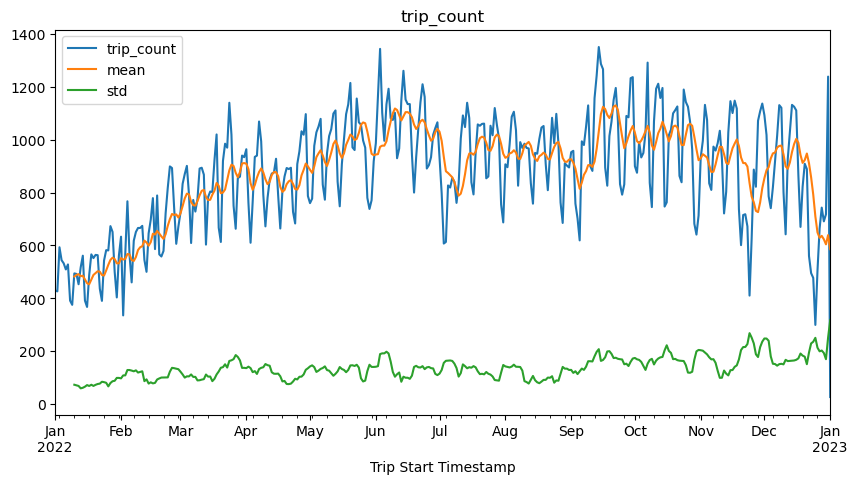

In [85]:
for col in temp_df_1year.columns:
    temp = pd.DataFrame(temp_df_1year[col])
    temp['mean'] = temp_df_1year[col].rolling(10).mean()
    temp['std'] = temp_df_1year[col].rolling(10).std()
    temp.plot(figsize=(10,5))
    plt.title(f'{col}')
    plt.show();

## Подготовка к обучению

Подготовим датафрейм к работе

In [177]:
for col in df.columns:
    df = df.withColumnRenamed(col, col.lower().replace(' ', '_'))
df = df.na.drop(subset=["pickup_community_area"])

df.registerTempTable("data")

Сформируем датафрейм сгруппированный по интервалам в час и по округам со следующими признаками:
- 1) Время
- 2) Округ
- 3) Кол-во уникальных машин в округе
- 4) Кол-во заказов за текущий час
- 5) Лаг от кол-ва заказов с шагами от 1 до 24 часов
- 6) Лид от кол-ва заказов с шагом в 1 час <strong>(целевой признак)</strong>

In [325]:
df = spark.sql(
    "WITH table AS \
    (SELECT DATE_TRUNC('hour', trip_start_timestamp) as timestamp, \
    pickup_community_area as area, \
    COUNT(trip_id) AS current_orders, \
    COUNT(DISTINCT(taxi_id)) AS unique_taxi \
    FROM data \
    GROUP BY DATE_TRUNC('hour', trip_start_timestamp), pickup_community_area \
    ORDER BY DATE_TRUNC('hour', trip_start_timestamp), pickup_community_area) \
    SELECT timestamp, \
    area, \
    unique_taxi, \
    current_orders, \
    LAG(current_orders, 1) OVER (ORDER BY timestamp, area) AS lag1, \
    LAG(current_orders, 2) OVER (ORDER BY timestamp, area) AS lag2, \
    LAG(current_orders, 3) OVER (ORDER BY timestamp, area) AS lag3, \
    LAG(current_orders, 4) OVER (ORDER BY timestamp, area) AS lag4, \
    LAG(current_orders, 5) OVER (ORDER BY timestamp, area) AS lag5, \
    LAG(current_orders, 6) OVER (ORDER BY timestamp, area) AS lag6, \
    LAG(current_orders, 7) OVER (ORDER BY timestamp, area) AS lag7, \
    LAG(current_orders, 8) OVER (ORDER BY timestamp, area) AS lag8, \
    LAG(current_orders, 9) OVER (ORDER BY timestamp, area) AS lag9, \
    LAG(current_orders, 10) OVER (ORDER BY timestamp, area) AS lag10, \
    LAG(current_orders, 11) OVER (ORDER BY timestamp, area) AS lag11, \
    LAG(current_orders, 12) OVER (ORDER BY timestamp, area) AS lag12, \
    LAG(current_orders, 13) OVER (ORDER BY timestamp, area) AS lag13, \
    LAG(current_orders, 14) OVER (ORDER BY timestamp, area) AS lag14, \
    LAG(current_orders, 15) OVER (ORDER BY timestamp, area) AS lag15, \
    LAG(current_orders, 16) OVER (ORDER BY timestamp, area) AS lag16, \
    LAG(current_orders, 17) OVER (ORDER BY timestamp, area) AS lag17, \
    LAG(current_orders, 18) OVER (ORDER BY timestamp, area) AS lag18, \
    LAG(current_orders, 19) OVER (ORDER BY timestamp, area) AS lag19, \
    LAG(current_orders, 20) OVER (ORDER BY timestamp, area) AS lag20, \
    LAG(current_orders, 21) OVER (ORDER BY timestamp, area) AS lag21, \
    LAG(current_orders, 22) OVER (ORDER BY timestamp, area) AS lag22, \
    LAG(current_orders, 23) OVER (ORDER BY timestamp, area) AS lag23, \
    LAG(current_orders, 24) OVER (ORDER BY timestamp, area) AS lag24, \
    LEAD(current_orders, 1) OVER (ORDER BY timestamp, area) AS target \
    FROM table \
    ORDER BY timestamp"
)

Выделим из timestamp доступные нам данные о дате и времени.

In [300]:
df = df.withColumn('year',year(df.timestamp))
df = df.withColumn('month',month(df.timestamp))
df = df.withColumn('day_of_year',dayofyear(df.timestamp))
df = df.withColumn('day_of_month',dayofmonth(df.timestamp))
df = df.withColumn('day_of_week',dayofweek(df.timestamp))
df = df.withColumn('hour',hour(df.timestamp))

+-------------------+----+-----------+--------------+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+----+-----+-----------+------------+-----------+----+
|          timestamp|area|unique_taxi|current_orders|lag1|lag2|lag3|lag4|lag5|lag6|lag7|lag8|lag9|lag10|lag11|lag12|lag13|lag14|lag15|lag16|lag17|lag18|lag19|lag20|lag21|lag22|lag23|lag24|target|year|month|day_of_year|day_of_month|day_of_week|hour|
+-------------------+----+-----------+--------------+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+----+-----+-----------+------------+-----------+----+
|2022-01-01 00:00:00|  45|          1|             1|   1|   2|   2|   1|   7|  37|  42|   2|   3|   20|    1|    8|    2|    1|    2|    2|    1|  190|   25|   32|    2|    9|    3|    1|     1|2022|    1|          1|           1|          7|   0|
|202

Удалим из полученного датафрейма строки с пропусками

In [277]:
df = df.na.drop()

Выделим колонки с признаками. Преобразуем их в вектор признаков (для линейной регрессии). Затем стандартизируем этот вектор.

In [301]:
featureCols = ['year', 'month', 'day_of_year', 'day_of_month', 'day_of_week', 'hour',
               'area', 'unique_taxi', 'current_orders', 
               'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 
               'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 
               'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 
               'lag16', 'lag17', 'lag18', 'lag19', 'lag20', 
               'lag21', 'lag22', 'lag23', 'lag24']

assembler = VectorAssembler(inputCols=featureCols, outputCol="features")
assembled_df = assembler.transform(df)
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")
scaled_df = standardScaler.fit(assembled_df).transform(assembled_df)

Разделим наши данные на три выборки: обучающую (80% данных), валидационную (10%) и тестовую (10%).

In [378]:
def make_subsets(dataframe, train_size=0.8):
    
    train_len = int(dataframe.count() * train_size)
    train = dataframe.limit(train_len)
    temp = dataframe.subtract(train)
    val_len = int(temp.count() * 0.5)
    val = temp.limit(val_len)
    test = temp.subtract(val)
    
    return train, val, test


train, val, test = make_subsets(scaled_df)

## Обучение моделей

Для решения стоящей перед нами задачи регрессии были выбраны следующие модели:
1) LinearRegression
2) DecisionTreeRegressor
3) RandomForestRegressor
4) FMRegressor
5) GBTRegressor
6) XGBRegressor (SparkXGBRegressor)

In [414]:
def model_metrics(model):
    
    try:
        importances = model.featureImportances.toArray()
        plt.figure(figsize=(15, 5))
        plt.title('Feature importances')
        plt.bar(featureCols, importances)
        plt.xticks(rotation=90)
        plt.show()
        
    except: pass
        
    try:
        print(f"RMSE модели: {model.summary.rootMeanSquaredError}, R2 модели: {model.summary.r2}")
        
    except: pass


def subset_metrics(model, subset_name='val'):
    
    if subset_name == 'val':
        subset = val
        
    elif subset_name == 'test':
        subset = test
        
    predictions = model.transform(subset)
    
    y_true = predictions.select('target').toPandas()
    y_pred = predictions.select('predicted').toPandas()
    
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    
    print(f"RMSE на {subset_name}: {rmse}, R2 на {subset_name}: {r2}")

### Сравнение базовых моделей

#### LinearRegression

In [416]:
lr = LinearRegression(featuresCol='features_scaled', labelCol="target", predictionCol='predicted',
                      standardization=False)
linearModel = lr.fit(train)
model_metrics(linearModel)
subset_metrics(linearModel)

RMSE модели: 42.33433167471557, R2 модели: 0.0627447889707533
RMSE на val: 49.802540083006974, R2 на val: 0.06587826987834433


#### DecisionTreeRegressor

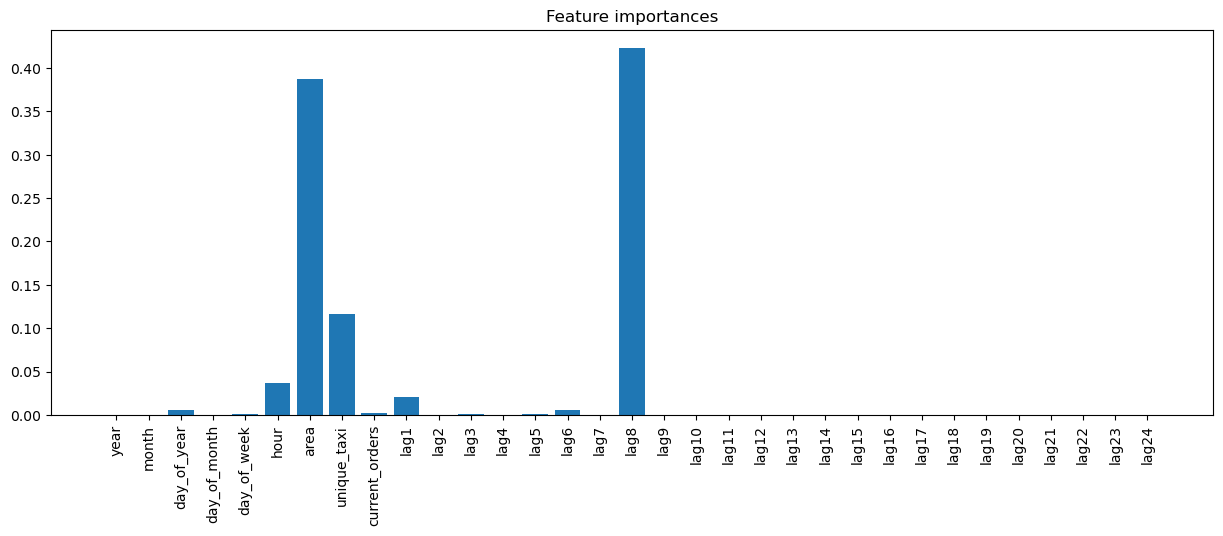

RMSE на val: 33.843474700507805, R2 на val: 0.568629562623898


In [413]:
dtr = DecisionTreeRegressor(featuresCol='features_scaled', labelCol="target", predictionCol='predicted', seed=state)
dtModel = dt.fit(scaled_train)
model_metrics(dtrModel)
subset_metrics(dtrModel)

#### RandomForestRegressor

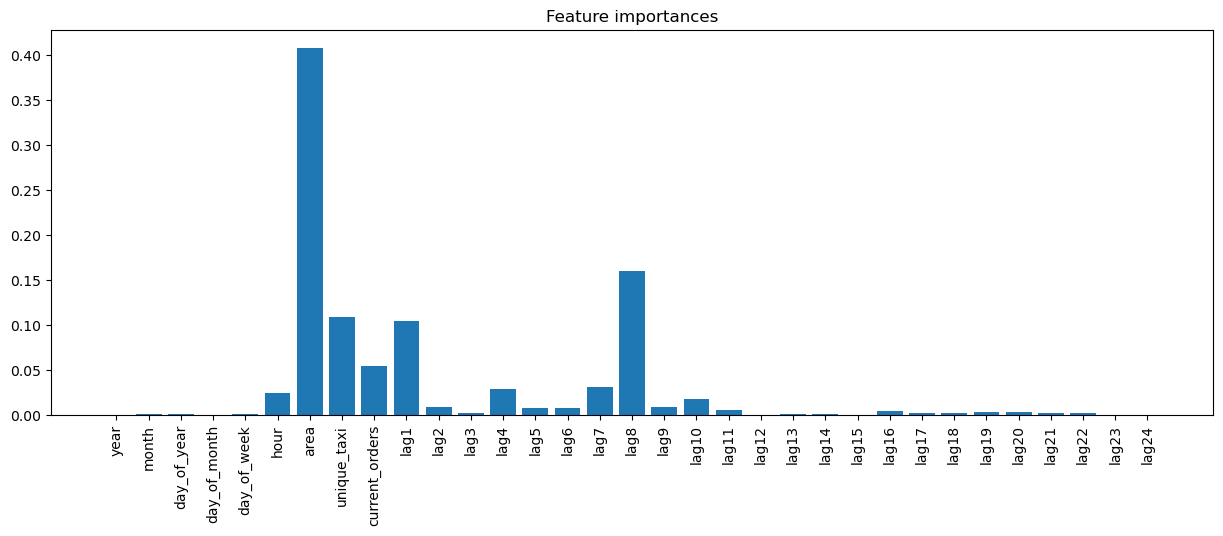

RMSE на val: 38.057336268074586, R2 на val: 0.45452197060214483


In [417]:
rfr = RandomForestRegressor(featuresCol='features_scaled', labelCol="target", predictionCol='predicted', seed=state)
rfModel = dt.fit(scaled_train)
model_metrics(rfrModel)
subset_metrics(rfrModel)

#### FMRegressor

In [ ]:
fmr = FMRegressor(featuresCol='features_scaled', labelCol="target", predictionCol='predicted', seed=state)
fmrModel = fmr.fit(scaled_train)
model_metrics(fmrModel)
subset_metrics(fmrModel)

#### GBTRegressor

In [ ]:
gbtr = GBTRegressor(featuresCol='features_scaled', labelCol="target", predictionCol='predicted', seed=state)
gbtrModel = gbtr.fit(scaled_train)
model_metrics(gbtrModel)
subset_metrics(gbtrModel)

#### XGBRegressor

In [ ]:
xgbr = SparkXGBRegressor(featuresCol='features_scaled', labelCol="target", predictionCol='predicted', seed=state)
xgbrModel = xgbr.fit(scaled_train)
model_metrics(xgbrModel)
subset_metrics(xgbrModel)

Разделим данные на обучающую, валидационную и тестовую выборки.